# The predictive power of real government bond yields

This notebook serves as an illustration of the points discussed in the post ["The predictive power of real government bond yields"](https://research.macrosynergy.com/the-predictive-power-of-real-government-bond-yields/) available on the Macrosynergy website. 

Real government bond yields are indicators of standard market risk premia and implicit subsidies. They can be estimated by subtracting an estimate of inflation expectations from standard yields. And for credible monetary policy regimes, inflation expectations can be estimated based on concurrent information on recent CPI trends and the future inflation target. For a data panel of developed markets since 2000, real yields have displayed strong predictive power for subsequent monthly and quarterly government bond returns. Simple real yield-based strategies have added material economic value in 2000-2023 by managing both intertemporal and cross-country risk allocation.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including building realative yield categories by subtracting an estimate of inflation expectations from standard yields.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting a few simple, but powerful trading strategies targeting, in particular, for directional and relative government bond returns. The strategies utilize real yield indicators derived in the previous section.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Run only if needed!
"""!pip install macrosynergy --upgrade"""

'!pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

In [3]:
# Bond-specific cross-sections

cids_dmca = ["AUD", "EUR", "JPY", "NZD", "GBP", "USD"]
cids_ea = ["DEM", "FRF", "ESP", "ITL"]  # major Euro currencies before EUR
cids = cids_dmca + cids_ea

cids_xeu = [
    cid for cid in cids if cid is not "EUR"
]  # list of all cross-sections except EUR
cids_be = [
    "AUD",
    "GBP",
    "JPY",
    "USD",
]  # cross-sections with breakeven inflation rate, liquid inflation-linked government bond markets

In [4]:
# Category tickers

# Feature categories

govs = ["GGOBGDPRATIO_NSA", "GGPBGDPRATIO_NSA"]  # General government finance ratios
infs = [
    "INFE2Y_JA",
    "INFE5Y_JA",
    "INFTEFF_NSA",
    "IMPINFB5Y_NSA",
]  # Effective inflation target and Inflation expectations (Macrosynergy method)

ecos = govs + infs

ylds = ["GB05YYLD_NSA"]  # 5-year government bond yield
sprds = ["CDS05YSPRD_NSA"]  # 5-year credit default swap spread
rirs = ["RIR_NSA"]  # Real interest rate

mkts = ylds + sprds + rirs

main = ecos + mkts

# Return categories

rets_cash = ["GB05YR_NSA"]  # 5-year government bond return
rets_lev = ["GB05YXR_NSA", "GB05YXR_VT10"]  # Generic government bond excess returns

rets = rets_cash + rets_lev

# All categoreis

xcats = main + rets

# Extra tickers

xtix = ["USD_EQXR_NSA"]  # USD equity futures excess returns

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + xtix
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 121


The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/), or [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected). For tickers used in this notebook see [General government finance ratios](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/General%20government%20finance%20ratios.php?highlight=ggdgdpratio), [Inflation expectations (Macrosynergy method)](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20expectations.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php?highlight=infteff), [Government bond returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Government%20bond%20returns.php), and [Real interest rates](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Real%20interest%20rates.php)

In [5]:
# Download series from J.P. Morgan DataQuery by tickers

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date="2000-01-01",
        suppress_warning=True,
        metrics=[
            "value",
        ],
        show_progress=True,
    )

Timestamp UTC:  2024-03-21 15:03:56
Connection successful!


Requesting data: 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
27 out of 121 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 6321 dates are missing.


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [6]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()
print(dfx["xcat"].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 490335 entries, 256457 to 490328
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  490335 non-null  datetime64[ns]
 1   cid        490335 non-null  object        
 2   xcat       490335 non-null  object        
 3   value      490335 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.7+ MB
['CDS05YSPRD_NSA' 'GB05YR_NSA' 'GB05YXR_NSA' 'GB05YXR_VT10' 'GB05YYLD_NSA'
 'GGOBGDPRATIO_NSA' 'GGPBGDPRATIO_NSA' 'IMPINFB5Y_NSA' 'INFE2Y_JA'
 'INFE5Y_JA' 'INFTEFF_NSA' 'RIR_NSA' 'EQXR_NSA']


# Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

In [7]:
msm.missing_in_df(df, xcats=xcats, cids=cids)

Missing xcats across df:  []
Missing cids for CDS05YSPRD_NSA:  ['EUR']
Missing cids for GB05YR_NSA:  ['EUR']
Missing cids for GB05YXR_NSA:  ['EUR']
Missing cids for GB05YXR_VT10:  ['EUR']
Missing cids for GB05YYLD_NSA:  ['EUR']
Missing cids for GGOBGDPRATIO_NSA:  []
Missing cids for GGPBGDPRATIO_NSA:  []
Missing cids for IMPINFB5Y_NSA:  ['FRF', 'EUR', 'NZD', 'ITL', 'ESP', 'DEM']
Missing cids for INFE2Y_JA:  ['ESP', 'ITL', 'DEM', 'FRF']
Missing cids for INFE5Y_JA:  ['ESP', 'ITL', 'DEM', 'FRF']
Missing cids for INFTEFF_NSA:  ['ESP', 'ITL', 'DEM', 'FRF']
Missing cids for RIR_NSA:  ['ESP', 'ITL', 'DEM', 'FRF']


Please, keep in mind that the Effective inflation target, Inflation expectations (Macrosynergy method), and Real interest rates data are not individually available for Eurozone countries. These data points are only accessible for the entire EUR zone. We will need to populate these specific categories for individual countries separately.

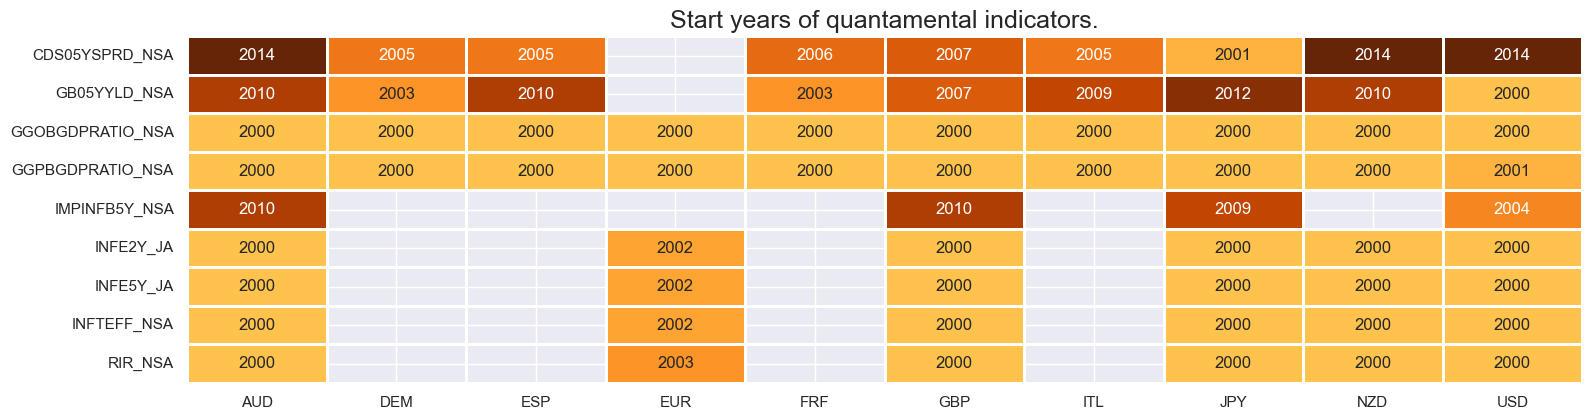

In [8]:
msm.check_availability(df, xcats=main, cids=cids, missing_recent=False)

Government bond yields are individually available for Eurozone countries:

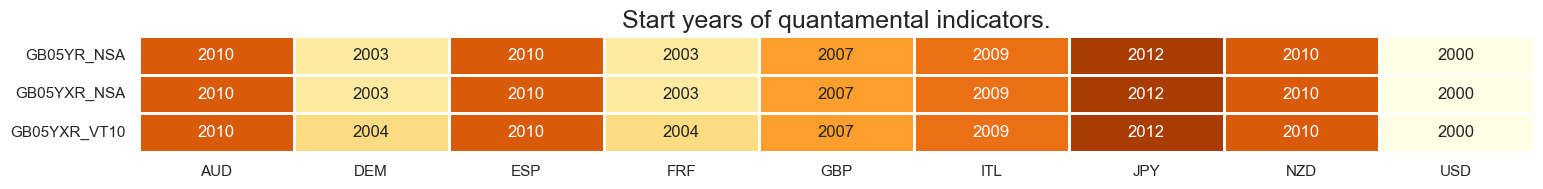

In [9]:
msm.check_availability(df, xcats=rets, cids=cids, missing_recent=False)

# Transformations and checks

## Features

### Real yields

The following cell fills in the Real interest rates, Inflation expectations, and Inflation targets (denoted as ["RIR_NSA", "INFE2Y_JA", "INFE5Y_JA", "INFTEFF_NSA"]) for the primary Eurozone currencies ['DEM', 'ESP', 'FRF', 'ITL']. Essentially, it duplicates the EUR values and assigns them to their respective currencies. 

In [10]:
cidx = cids_ea
xcatx = ["RIR_NSA", "INFE2Y_JA", "INFE5Y_JA", "INFTEFF_NSA"]

calcs = [f"{xc}=  iEUR_{xc} + GB05YXR_NSA - GB05YXR_NSA" for xc in xcatx]


dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

In this particular context, we establish the real 5-year bond yields by subtracting the corresponding government bond yields from the corresponding inflation expectations, following the guidelines provided by [the Macrosynergy method](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20expectations.php). This new indicator is named `GB05YRYLD_NSA`

For certain countries with reasonably well-developed inflation-linked government bond markets, such as Australia, the UK, Japan, and the United States, it is possible to derive breakeven inflation rates for the 5-year maturity, along with related real yields. This newly derived indicator is named `GB05YRYLD_BE`.

In [11]:
cidx = cids_xeu

calcs = [
    "GB05YRYLD_NSA = GB05YYLD_NSA - INFE5Y_JA",
    "GB05YRYLD_BE = GB05YYLD_NSA - IMPINFB5Y_NSA",
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

The real 5-year bond real and nominal yields are displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

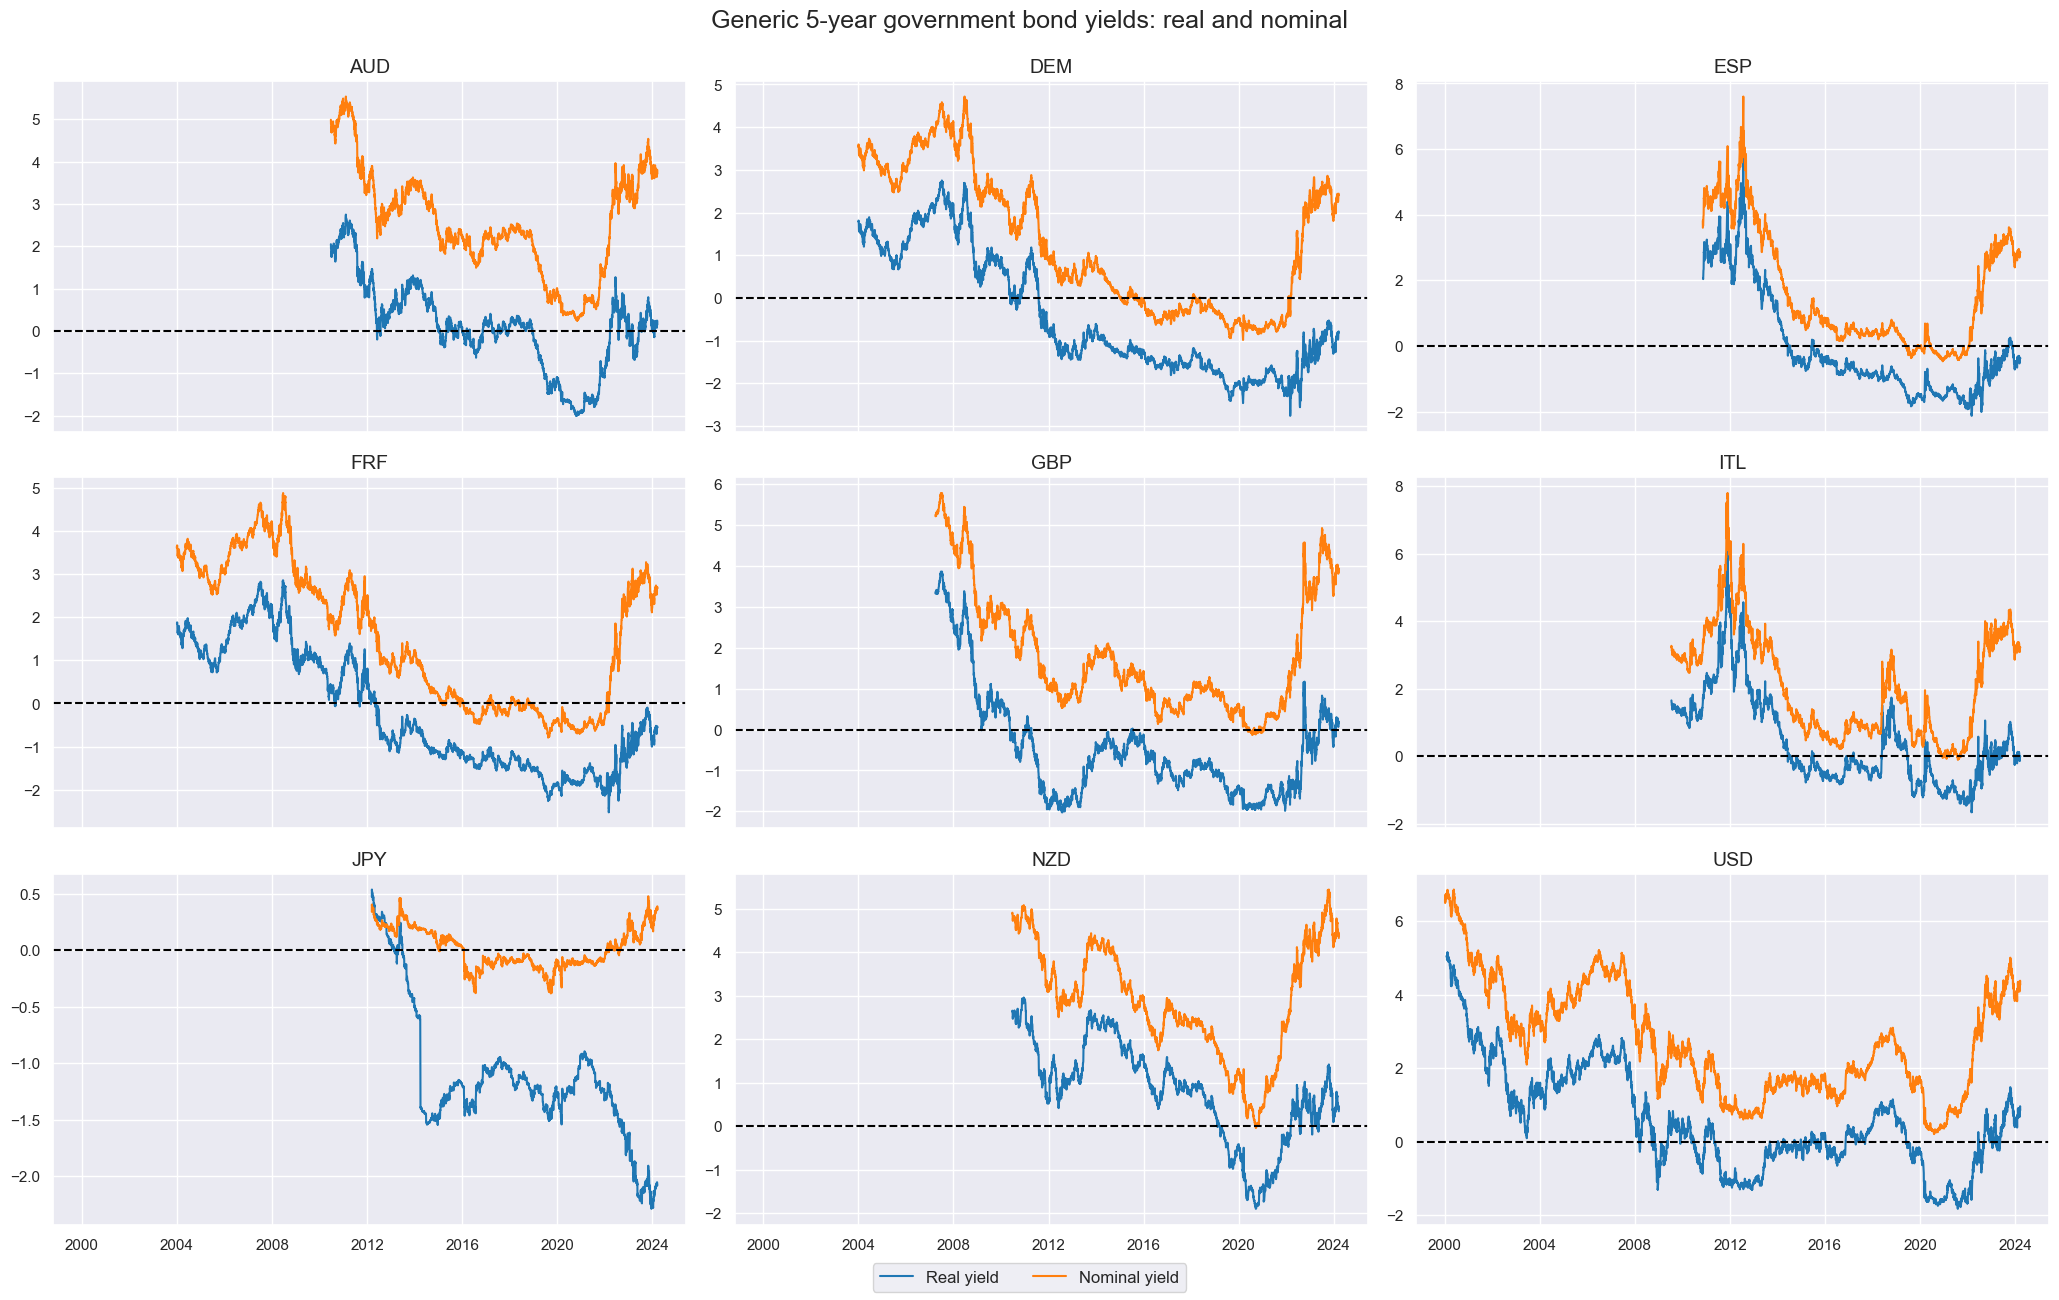

In [12]:
cidx = cids_xeu
xcatx = ["GB05YRYLD_NSA", "GB05YYLD_NSA"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title="Generic 5-year government bond yields: real and nominal",
    xcat_labels=["Real yield", "Nominal yield"],
)

For Australia, the UK, Japan, and the United States we display breakeven inflation rates for the 5-year maturity, along with related real yields

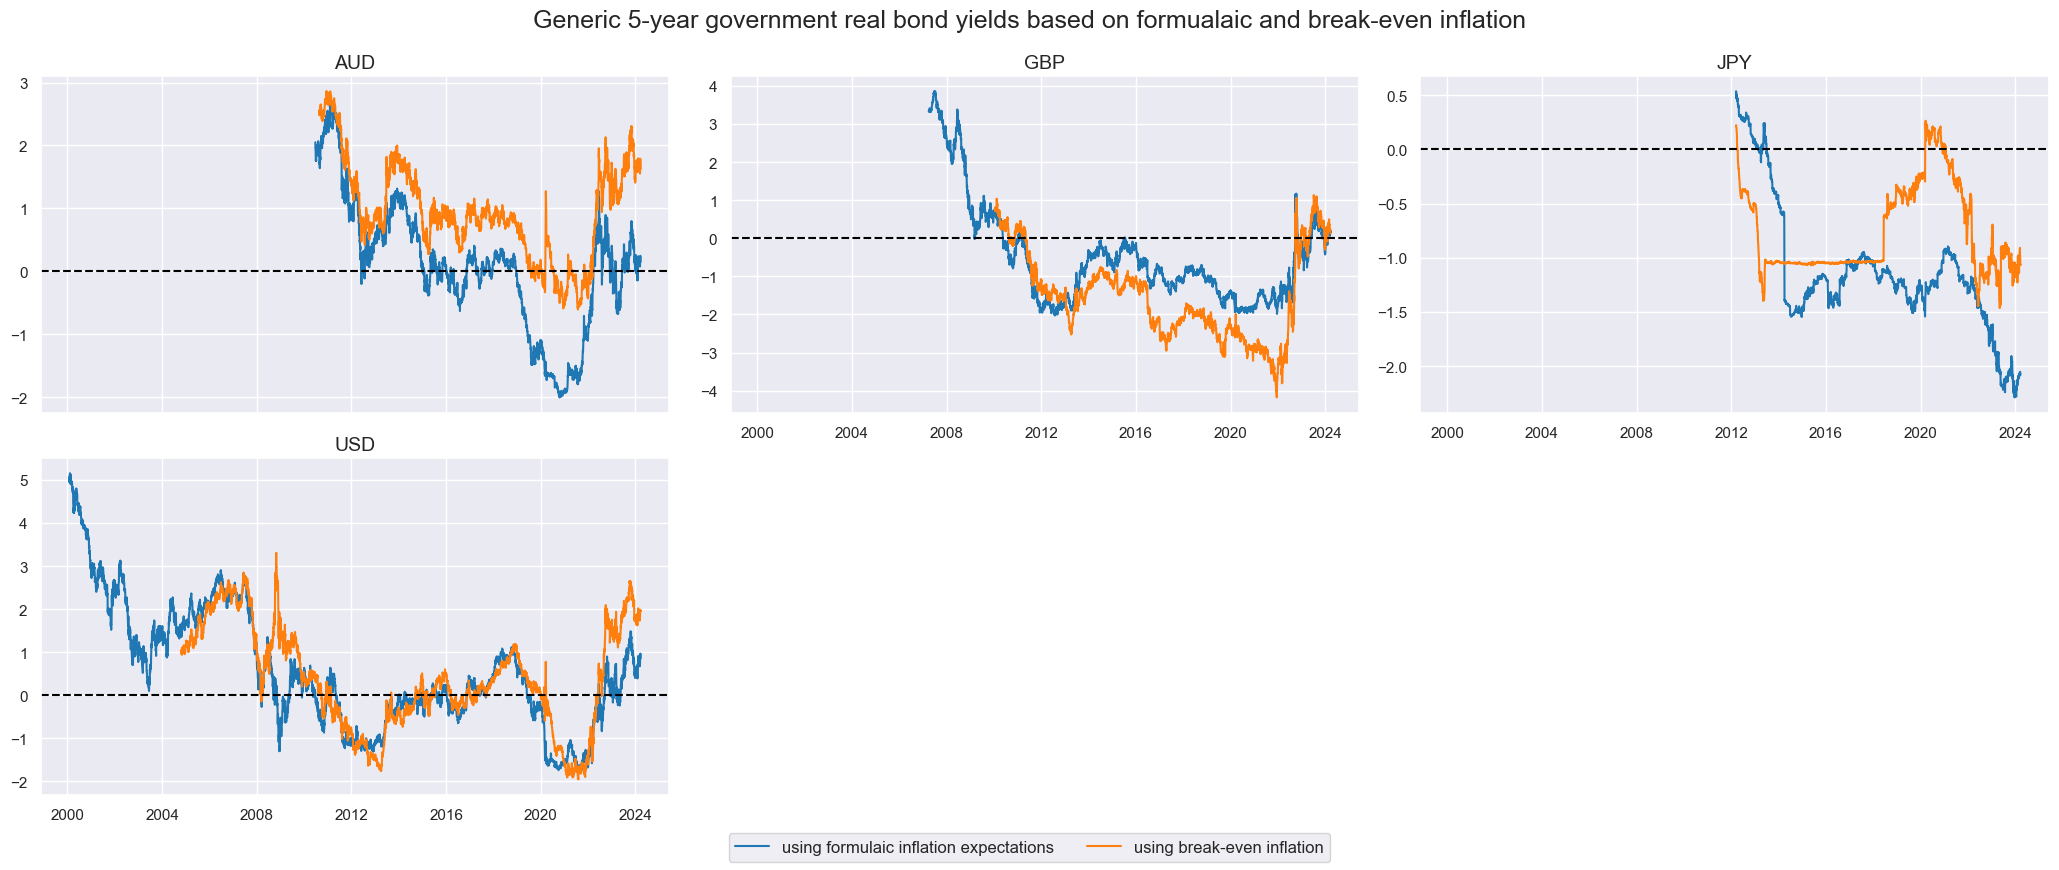

In [13]:
cidx = cids_be
xcatx = ["GB05YRYLD_NSA", "GB05YRYLD_BE"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title="Generic 5-year government real bond yields based on formualaic and break-even inflation",
    xcat_labels=[
        "using formulaic inflation expectations",
        "using break-even inflation",
    ],
)

### CDS adjustment

For the United States, CDS spreads are only available starting from 2014. Therefore, for periods prior to 2014, we assign a CDS spread value of 0 for the US data. Afterward, we calculate the CDS-adjusted real yields by subtracting the 5-year CDS spread from the previously calculated real yields.

In [14]:
xcatx = ["CDS05YSPRD_NSA", "GB05YRYLD_NSA"]

# Making USD CDS equal to 0 for history
dfu = dfx[((dfx["xcat"].isin(xcatx)) & (dfx["cid"] == "USD"))]
dfu = dfu.pivot(index="real_date", columns="xcat", values="value")
dfu = dfu[dfu["GB05YRYLD_NSA"].notna()]
dfu = dfu.fillna(0)
dfu = dfu.stack().reset_index(name="value")
dfu["cid"] = "USD"


dfx = msm.update_df(dfx, dfu)

cidx = cids_xeu

calcs = ["GB05YRYLD_CDA = GB05YRYLD_NSA - CDS05YSPRD_NSA"]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

Generic real 5-year government bond yields with and without CDS spread adjustment are displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

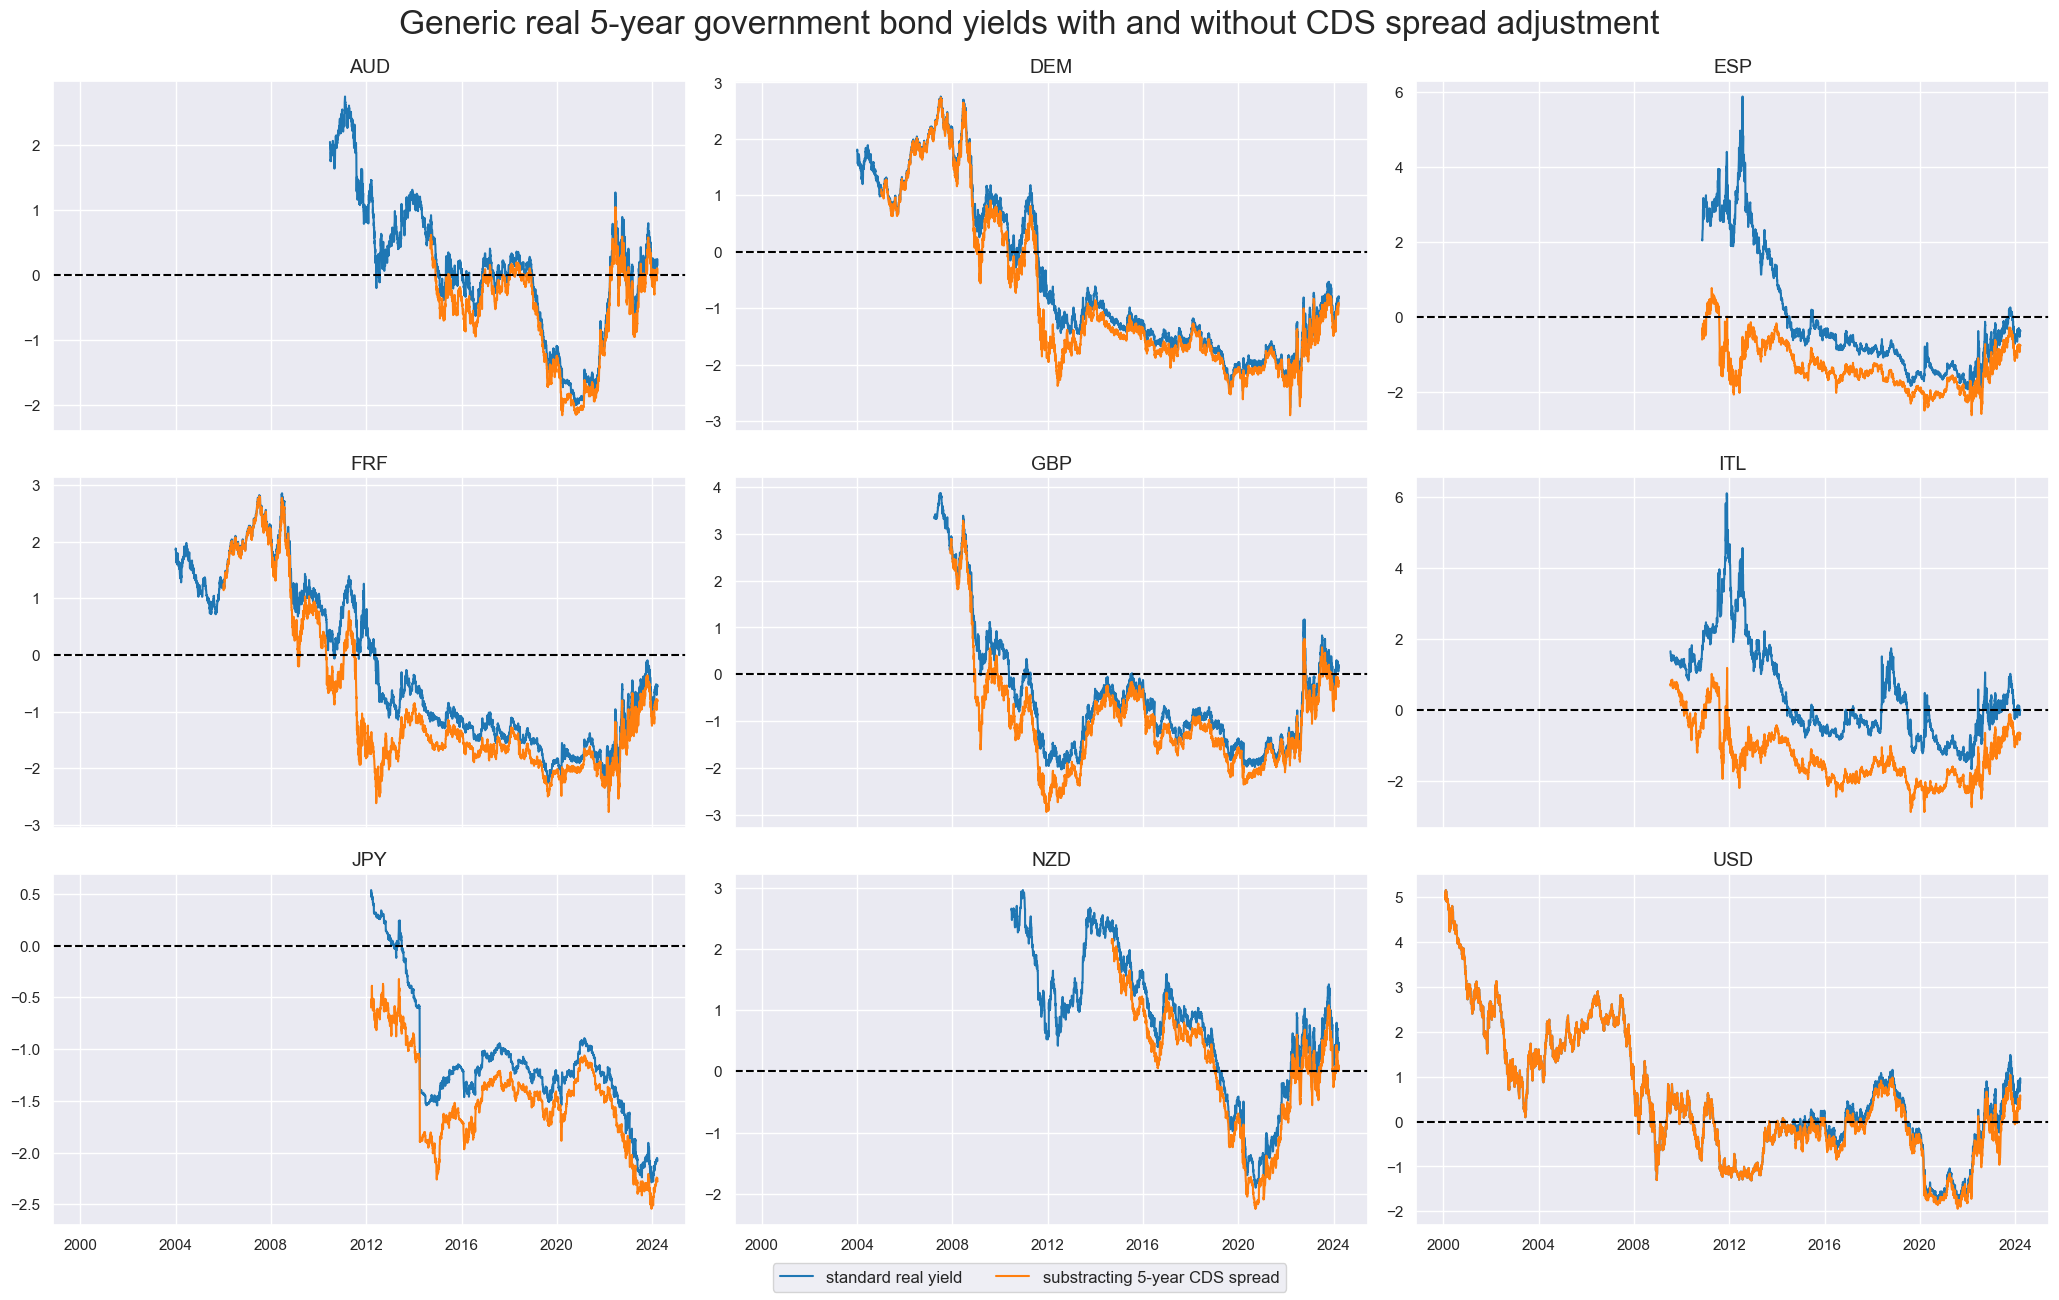

In [15]:
cidx = cids_xeu
xcatx = ["GB05YRYLD_NSA", "GB05YRYLD_CDA"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    title="Generic real 5-year government bond yields with and without CDS spread adjustment",
    title_fontsize=24,
    xcat_labels=["standard real yield", "substracting 5-year CDS spread"],
)

### Relative yields

We compute relative yields by comparing the yields of a single country to those of all other available countries during each time period. However, because we lack data for countries other than the United States in the earlier years of our dataset, this analysis can commence only from the year 2004. Moreover, we have a complete dataset containing data for all nine countries, but this information is only available for the 2010s.

In [16]:
cidx = cids_xeu
mats = ["02", "05", "10"]
adjs = ["NSA", "CDA"]
xcatx = [f"GB{mat}YRYLD_{adj}" for mat in mats for adj in adjs]

dfa = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    rel_meth="subtract",
    complete_cross=False,
    postfix="vBM",
)

dfx = msm.update_df(df=dfx, df_add=dfa)  # composite extended data frame

The resulting relative real 5-year bond real and CDS-adjusted versions are displayed with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

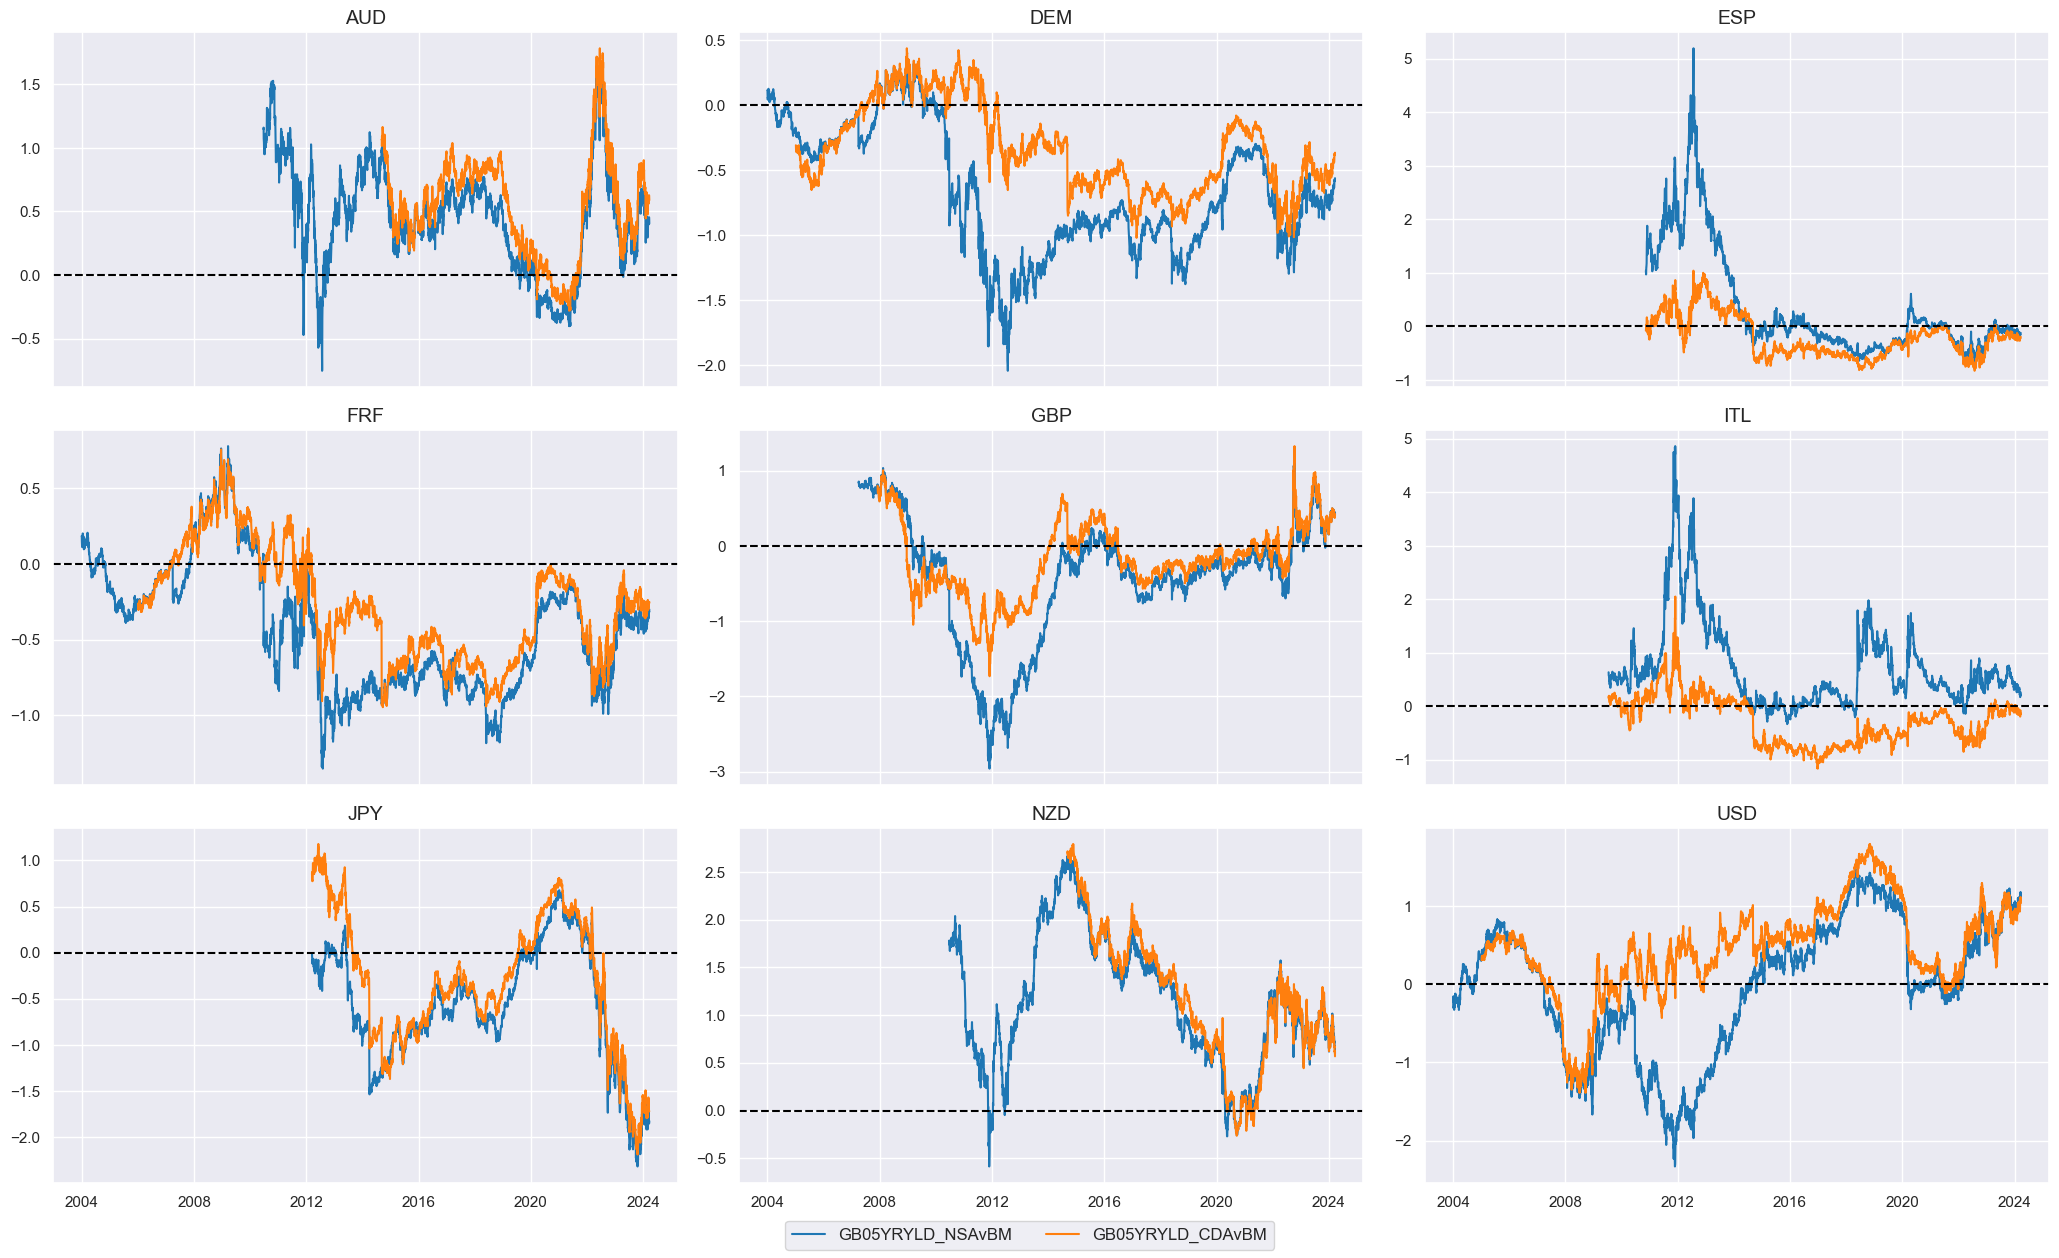

In [17]:
cidx = cids_xeu
xcatx = ["GB05YRYLD_NSAvBM", "GB05YRYLD_CDAvBM"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
   
)

## Targets

### Outright bond returns

As target we choose [generic government bond returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Government%20bond%20returns.php) as well as [Vol-targeted generic government bond excess returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Government%20bond%20returns.php). As the first step we display the timelines of the two categories of returns side by side. 

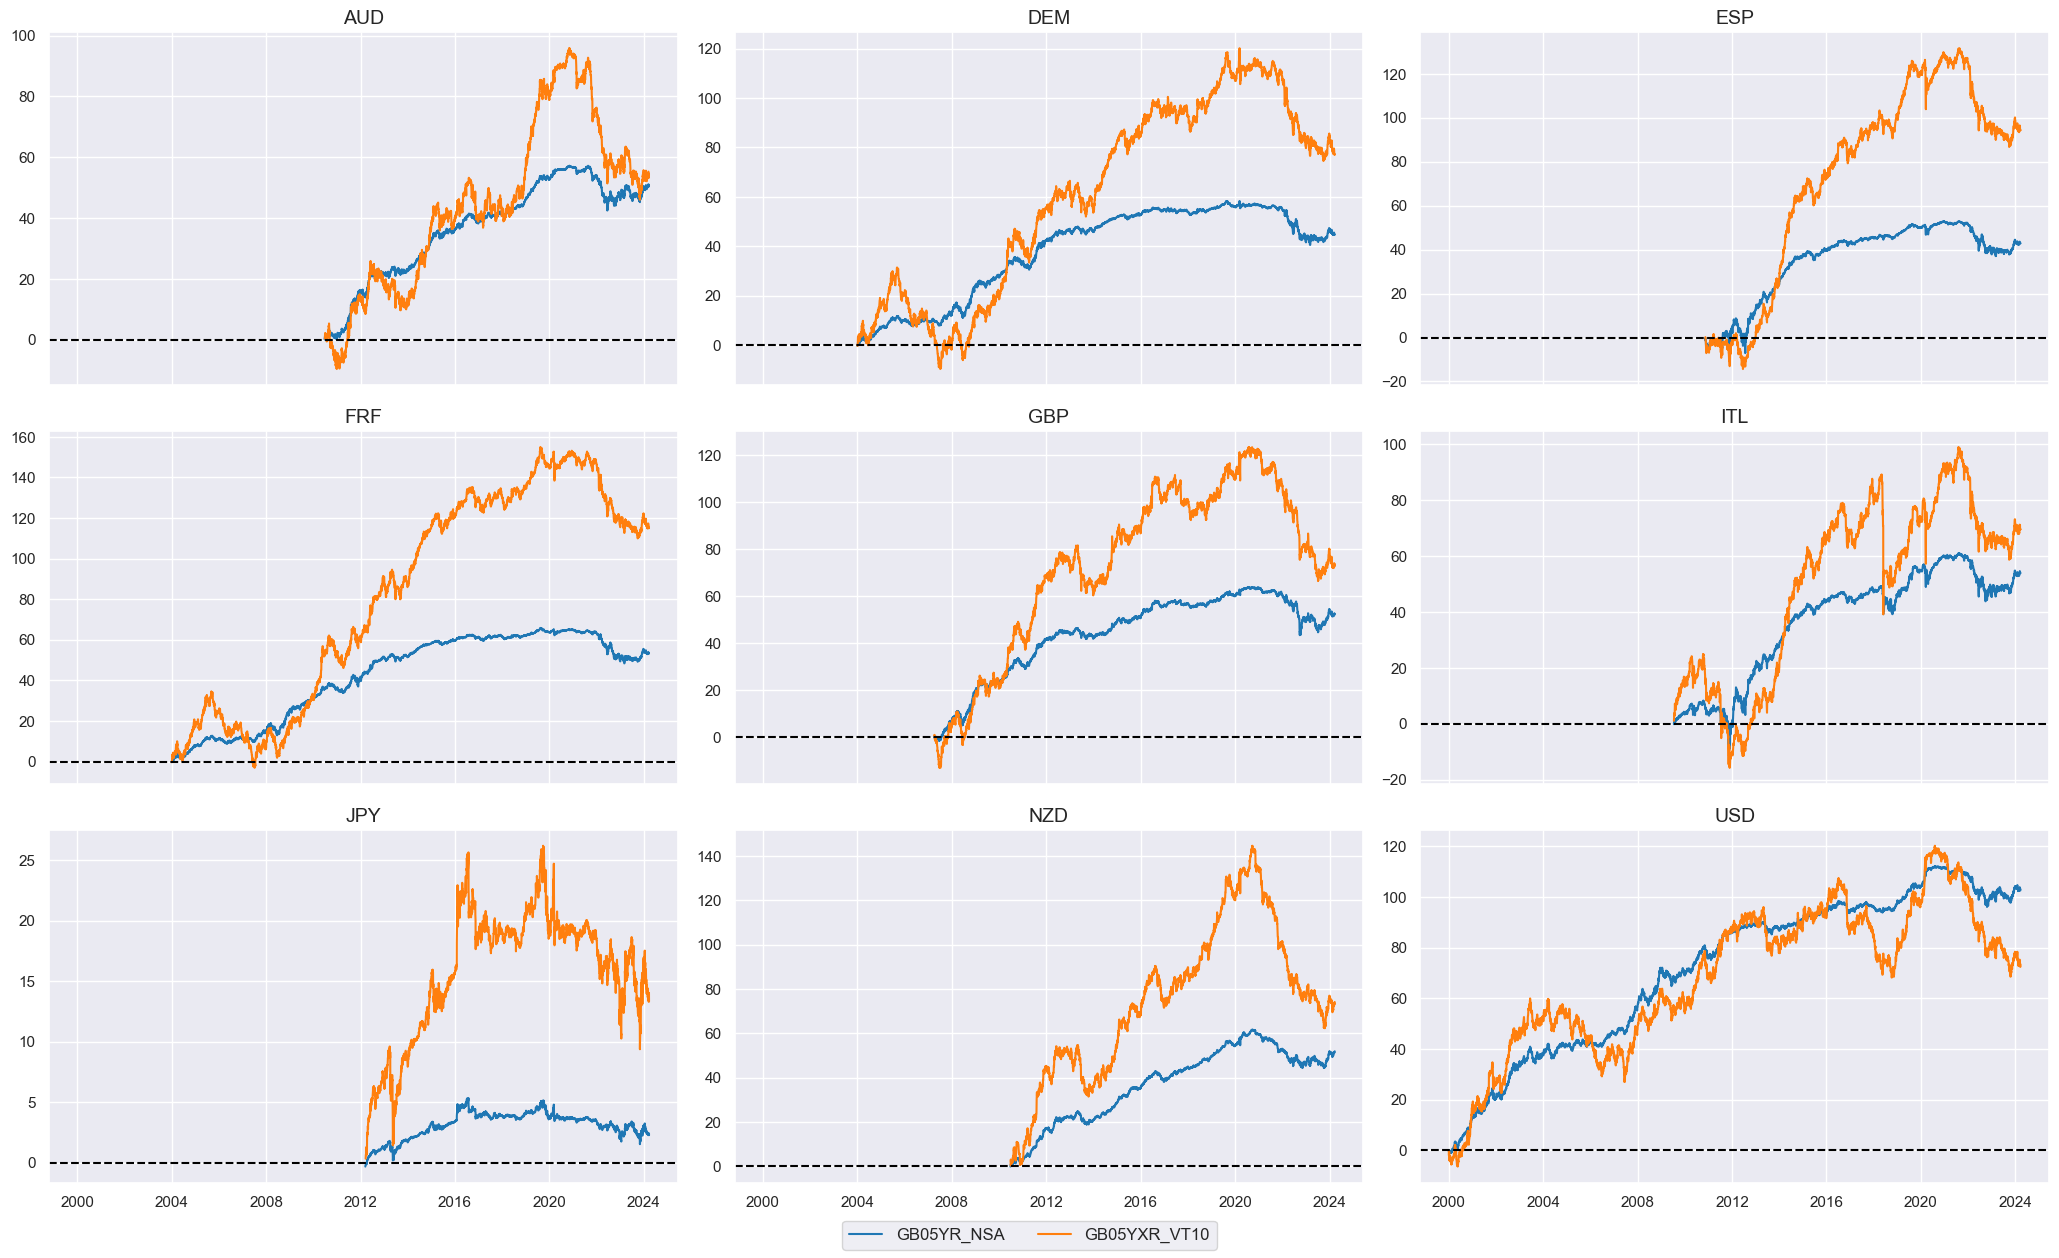

In [18]:
cidx = cids_xeu
xcatx = ["GB05YR_NSA", "GB05YXR_VT10"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    same_y=False,
    cumsum=True,
)

### Relative bond returns

To calculate relative bonds returns we use macrosynergy's function `make_relative_value()`, which calculates relative value for 5 years government bond yields against the basket of currencies. The new category receives postfix `_vBM`

In [19]:
cidx = cids_xeu
xcatx = ["GB05YR_NSA", "GB05YXR_VT10"]

dfy = msp.make_relative_value(
    dfx,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    rel_meth="subtract",
    complete_cross=False,
    postfix="vBM",
)

dfx = msm.update_df(df=dfx, df_add=dfy)  # composite extended data frame

Here the directional and relative 5 year bond returns are displayed side by side:

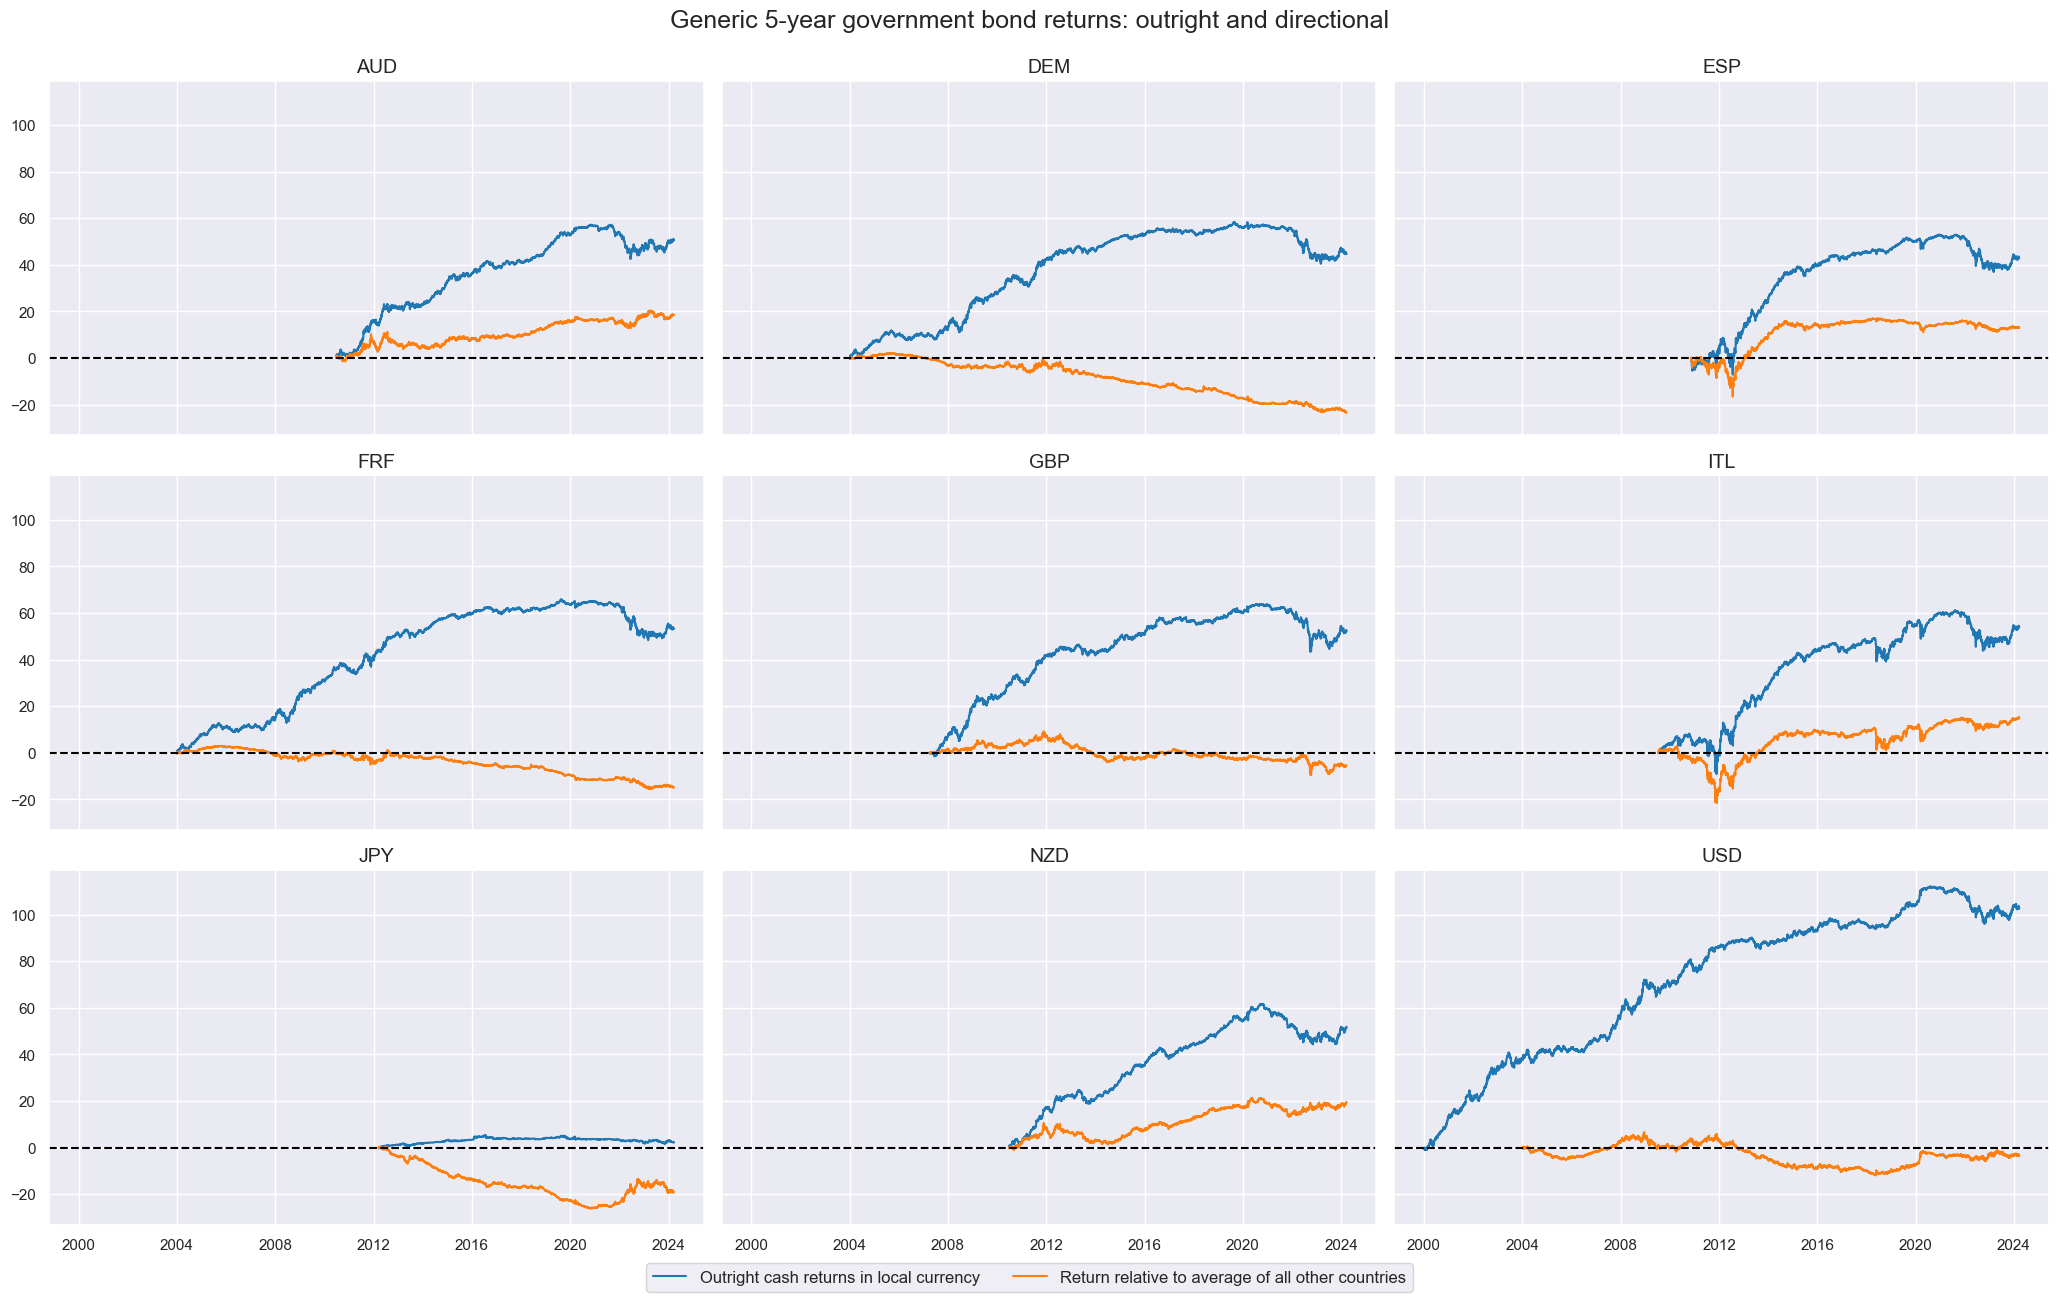

In [20]:
cidx = cids_xeu
xcatx = ["GB05YR_NSA", "GB05YR_NSAvBM"]

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    start="2000-01-01",
    cumsum=True,
    same_y=True,
    title="Generic 5-year government bond returns: outright and directional",
    xcat_labels=[
        "Outright cash returns in local currency",
        "Return relative to average of all other countries",
    ],
)

# Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for directional and relative government bond returns strategies using the previously derived real yields (with and without CDS adjustment). The PnLs are calculated based on simple trading strategies that utilize the yields as signals (no regression is involved). The strategies involve going long (buying) or short (selling) on commodity positions based purely on the direction of the score signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the changes in real yields and consequent bond returns. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of the confidence score based strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these simple confidence score strategies with the long-only performance of the respective asset classes. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

## 5-year real yields and directional returns

### Specs and panel tests

Consistent with previous notebooks, here we define 5-year real yield (`GB05YRYLD_NSA`) as the main signal and subsequent 5 year government bond yield as target. As additional signals we consider real interest rates (`RIR_NSA`) and CDS-adjuste real yields derive above (`GB05YRYLD_CDA`)

In [21]:
ms = "GB05YRYLD_NSA"  # main signal
oths = ["GB05YRYLD_CDA", "RIR_NSA"]  # other signals

targ = "GB05YR_NSA"
cidx = cids_xeu
start = "2000-01-01"

dict_ry5bd = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "srr": None,
    "pnls": None,
}

The below graph displays a panel scatter plot of quarter-end real 5-year government bond yields and subsequent quarterly returns. There has been a strong and highly significant positive relationship. Pearson correlation between period-end yield and next-period return has been over 40% at the quarterly frequency and 26% at the monthly frequency.

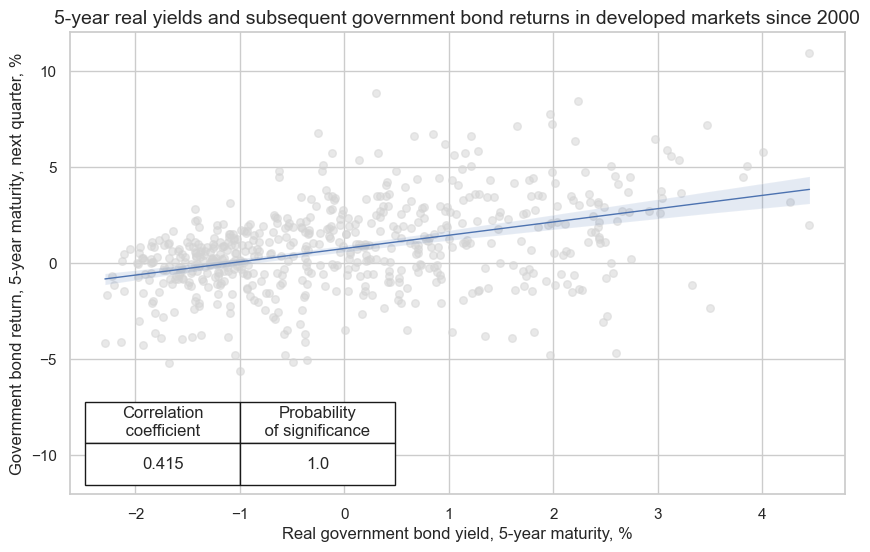

In [22]:
dix = dict_ry5bd

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Real government bond yield, 5-year maturity, %",
    ylab="Government bond return, 5-year maturity, next quarter, %",
    title="5-year real yields and subsequent government bond returns in developed markets since 2000",
    size=(10, 6),
    prob_est="map",
)

Using the U.S. time series alone, the quarterly correlation coefficient of real yields and subsequent returns remains 25% and is highly significant.

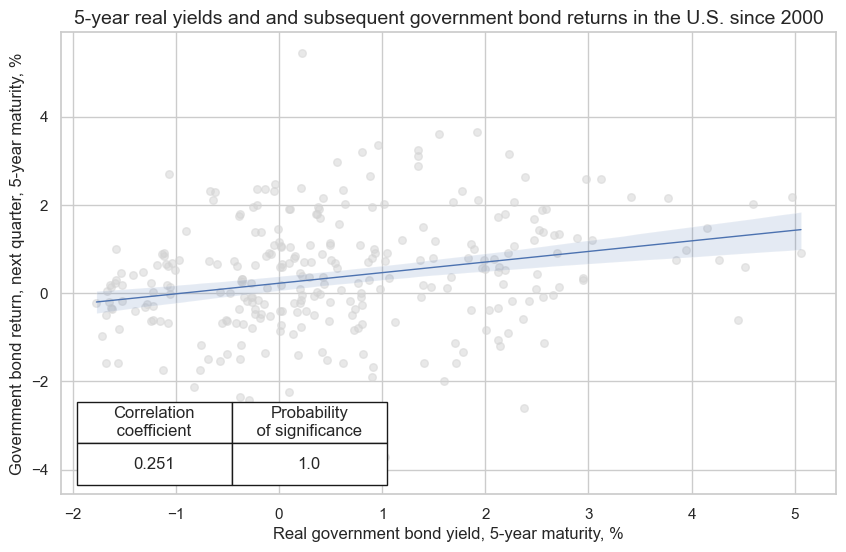

In [23]:
dix = dict_ry5bd

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=["USD"],
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Real government bond yield, 5-year maturity, %",
    ylab="Government bond return, next quarter, 5-year maturity, %",
    title="5-year real yields and and subsequent government bond returns in the U.S. since 2000",
    size=(10, 6),
    prob_est="map",
)

### Accuracy and correlation check

The `SignalReturnRelations` class from the macrosynergy.signal module is specifically designed to analyze, visualize and compare the relationships between panels of trading signals and panels of subsequent returns.

In [24]:
dix = dict_ry5bd

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start=start,
)

dix["srr"] = srr
srrx = dix["srr"]

The `.summary_table()` of the `SignalReturnRelations` class gives a short high-level snapshot of the strength and stability of the main signal relation.

In [25]:
display(srrx.summary_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
Panel,0.551,0.565,0.442,0.612,0.684,0.446,0.261,0.000,0.189,0.000,0.568
Mean years,0.600,0.595,0.604,0.630,0.635,0.300,0.245,0.191,0.169,0.201,0.534
Positive ratio,0.680,0.800,0.520,0.840,0.840,0.200,0.920,0.760,0.880,0.760,0.480
Mean cids,0.550,0.576,0.433,0.610,0.696,0.456,0.252,0.008,0.193,0.004,0.562
Positive ratio,0.889,1.000,0.333,1.000,1.000,0.111,1.000,1.000,1.000,1.000,1.000


For a comparative overview of the signal-return relationship across the main and rival signals, one can use the `signals_table()` method.

In [26]:
display(srrx.signals_table().sort_index().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
GB05YRYLD_CDA,0.492,0.559,0.251,0.605,0.694,0.425,0.203,0.0,0.160,0.0,0.547
GB05YRYLD_NSA,0.551,0.565,0.442,0.612,0.684,0.446,0.261,0.0,0.189,0.0,0.568
RIR_NSA,0.484,0.540,0.282,0.612,0.670,0.410,0.202,0.0,0.121,0.0,0.534


### Naive PnL

`NaivePnl()` class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not take into account transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

In [27]:
dix = dict_ry5bd

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]


naive_pnl = msn.NaivePnL(
    dfx, ret=targ, sigs=sigx, cids=cidx, start=start, bms=["USD_GB10YXR_NSA"]
)

dict_pnls = {
    "PZN": {"sig_add": 0, "sig_op": "zn_score_pan"},
    "PZNL": {"sig_add": 1, "sig_op": "zn_score_pan"},
    "BIN": {"sig_add": 0, "sig_op": "binary"},
    "BINL": {"sig_add": 1, "sig_op": "binary"},
}

for k, v in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=False,
            sig_add=v["sig_add"],
            sig_op=v["sig_op"],
            thresh=2,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_" + k,
        )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

USD_GB10YXR_NSA has no observations in the DataFrame.


The `plot_pnls()` method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL. 

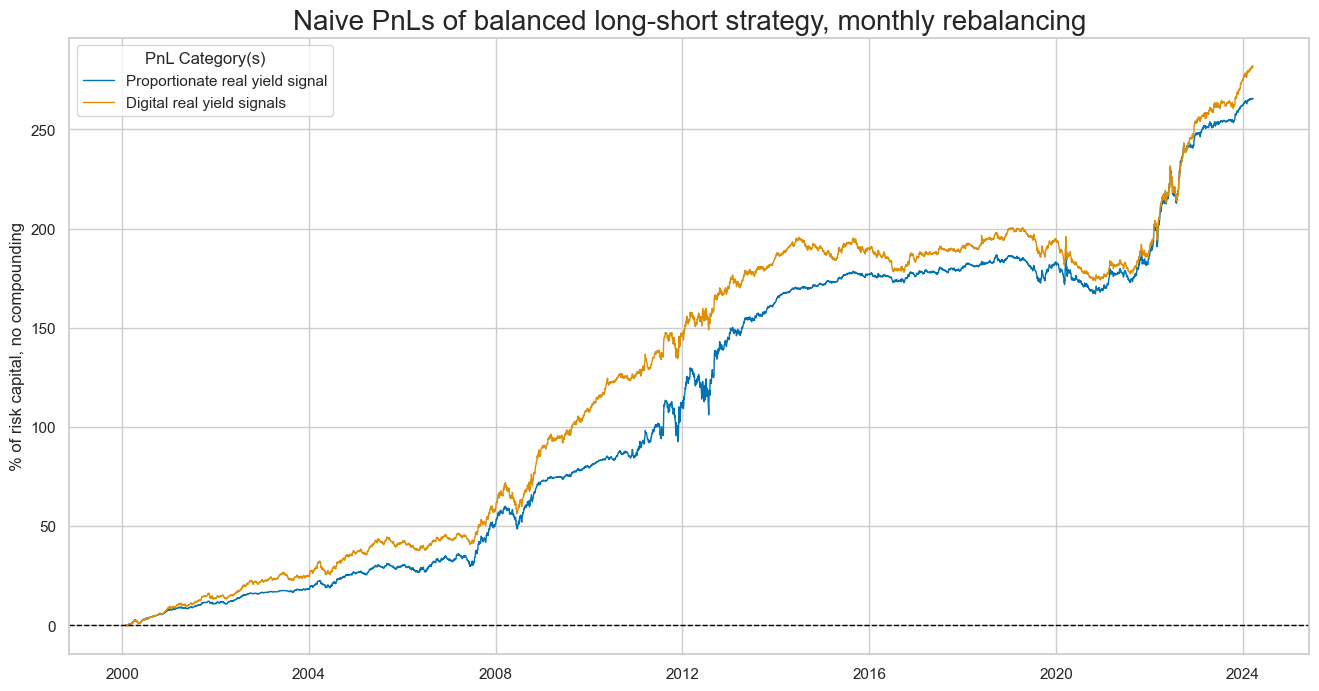

In [28]:
dix = dict_ry5bd

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]]

naive_pnl = dix["pnls"]
pnls = [sig + pos for sig in sigx for pos in ["_PZN", "_BIN"]]

dict_labels = {"GB05YRYLD_NSA_PZN": "Proportionate real yield signal", "GB05YRYLD_NSA_BIN": "Digital real yield signals"}


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive PnLs of balanced long-short strategy, monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The `signal_heatmap()` method is used to create a heatmap of signals for a specific PnL across time and sections. The time axis refers to period averages, and the default frequency is monthly (specified with freq=’m’), but quarterly is also an option (freq=’q’).

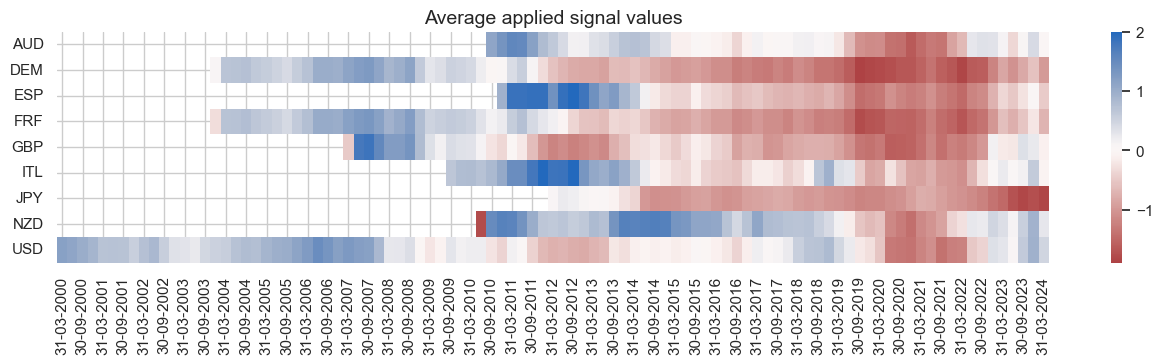

In [29]:
dix = dict_ry5bd

start = dix["start"]
sig = dix["sig"]
naive_pnl = dix["pnls"]

naive_pnl.signal_heatmap(pnl_name=sig + "_PZN", freq="q", start=start, figsize=(16, 3))

The `plot_pnls()` method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL. 

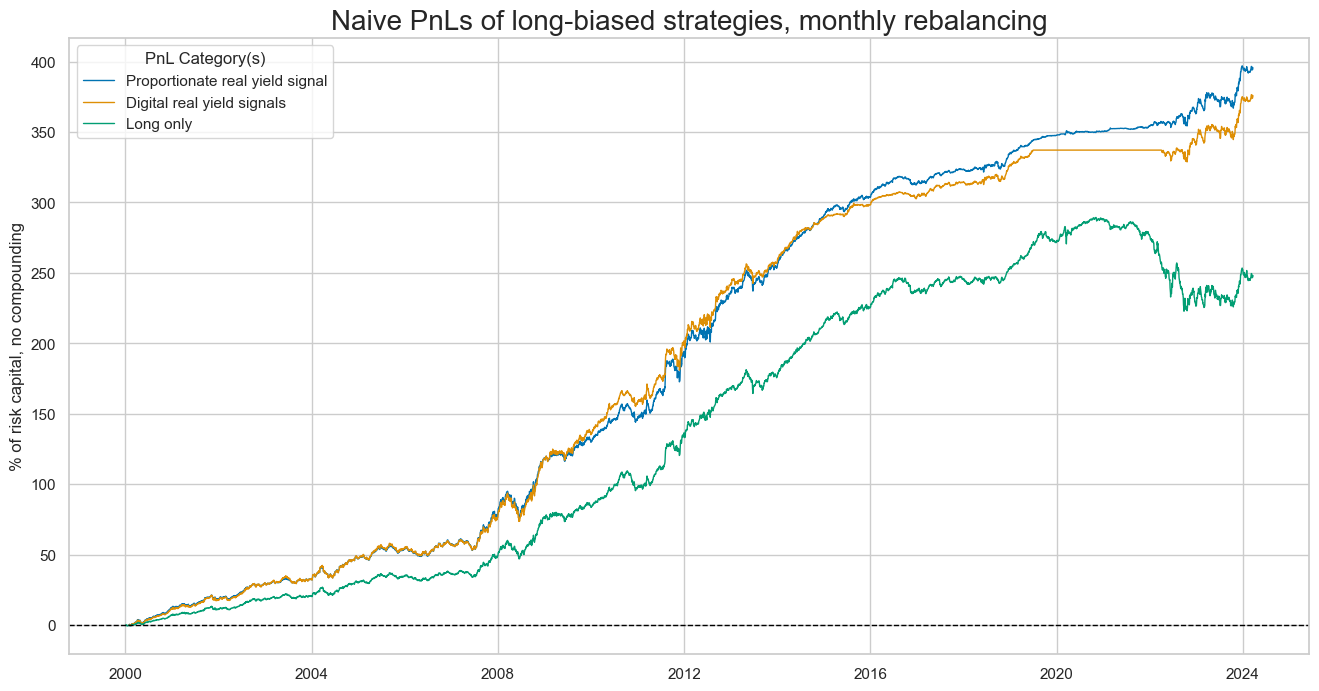

In [30]:
dix = dict_ry5bd

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]]

naive_pnl = dix["pnls"]
pnls = [sig + pos for sig in sigx for pos in ["_PZNL", "_BINL"]] + ["Long only"]
dict_labels={"GB05YRYLD_NSA_PZNL": "Proportionate real yield signal", "GB05YRYLD_NSA_BINL": "Digital real yield signals", "Long only": "Long only"}  

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive PnLs of long-biased strategies, monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

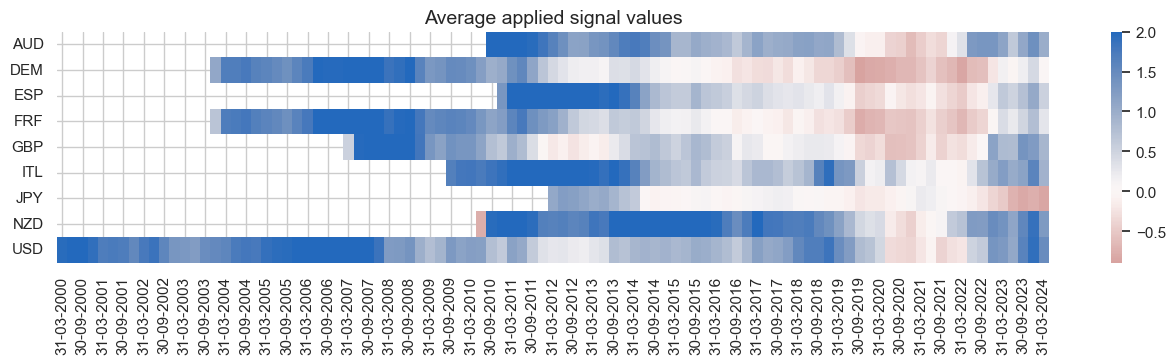

In [31]:
dix = dict_ry5bd

start = dix["start"]
sig = dix["sig"]
naive_pnl = dix["pnls"]

naive_pnl.signal_heatmap(pnl_name=sig + "_PZNL", freq="q", start=start, figsize=(16, 3))

The method evaluate_pnls() returns a small dataframe of key PnL statistics. For definitions of Sharpe and Sortino ratios please see [here](https://www.investopedia.com/ask/answers/010815/what-difference-between-sharpe-ratio-and-sortino-ratio.asp#:~:text=The%20Sharpe%20ratio%20indicates%20how,only%20factors%20in%20downside%20risk.)

In [32]:
dix = dict_ry5bd

start = dix["start"]
sigx = [dix["sig"]]
naive_pnl = dix["pnls"]
posx = ["_PZN", "_BIN", "_PZNL", "_BINL"]

pnls = [sig + pos for sig in sigx for pos in posx] + ["Long only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)

In [33]:
display(df_eval.transpose())

,Return (pct ar),St. Dev. (pct ar),Sharpe Ratio,Sortino Ratio,Max 21-day draw,Max 6-month draw,Traded Months
xcat,,,,,,,
GB05YRYLD_NSA_BIN,11.684139,10.0,1.168414,1.778367,-13.661037,-18.512134,291
GB05YRYLD_NSA_BINL,15.569303,10.0,1.55693,2.496428,-10.962053,-9.1977,291
GB05YRYLD_NSA_PZN,11.007433,10.0,1.100743,1.735573,-16.978587,-16.655314,291
GB05YRYLD_NSA_PZNL,16.389715,10.0,1.638972,2.654401,-10.987079,-9.55078,291
Long only,10.243928,10.0,1.024393,1.548027,-19.275884,-46.317617,291


## 5-year real yields and relative returns

### Specs and panel tests

Consistent with previous analysis, here we define relative to benmchmark 5-year real yield (`GB05YRYLD_NSAvBM`) as the main signal and subsequent relative 5 year government bond yield (`GB05YR_NSAvBM`) as target. As additional signals we consider  CDS-adjusted real yields derived above (`GB05YRYLD_CDAvBM`)

In [34]:
ms = "GB05YRYLD_NSAvBM"  # main signal
oths = ["GB05YRYLD_CDAvBM"]  # other signals

targ = "GB05YR_NSAvBM"
cidx = cids_xeu
start = "2000-01-01"

dict_ry5br = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "srr": None,
    "pnls": None,
}

Notwithstanding the data limitations, the predictive relation between relative real yields and subsequent relative returns looks strong and highly significant, according to the standard Pearson statistic and the Macrosynergy panel test. The quarterly correlation coefficient has been 35% for standard yields.

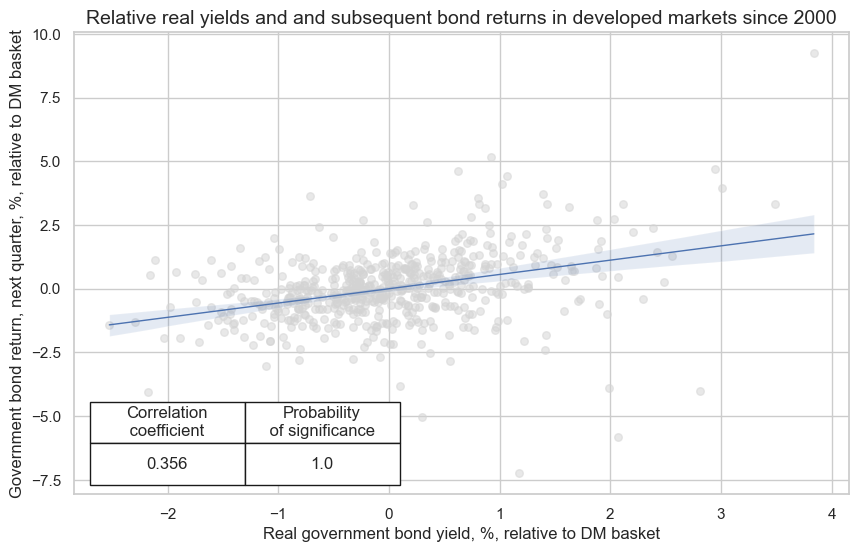

In [35]:
dix = dict_ry5br

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    xlab="Real government bond yield, %, relative to DM basket",
    ylab="Government bond return, next quarter, %, relative to DM basket",
    title="Relative real yields and and subsequent bond returns in developed markets since 2000",
    size=(10, 6),
    prob_est="map",
)

### Accuracy and correlation check

The `SignalReturnRelations` class from the macrosynergy.signal module is specifically designed to analyze, visualize and compare the relationships between panels of trading signals and panels of subsequent returns.

In [36]:
dix = dict_ry5br

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start=start,
)

dix["srr"] = srr
srrx = dix["srr"]

The `summary_table()` of the `SignalReturnRelations` class gives a short high-level snapshot of the strength and stability of the main signal relation.

In [37]:
display(srrx.summary_table().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
Panel,0.612,0.611,0.464,0.475,0.594,0.628,0.212,0.000,0.173,0.000,0.611
Mean years,0.615,0.613,0.468,0.474,0.599,0.627,0.231,0.207,0.176,0.207,0.612
Positive ratio,0.857,0.857,0.238,0.238,0.857,0.810,0.905,0.762,0.905,0.762,0.857
Mean cids,0.614,0.622,0.492,0.481,0.581,0.663,0.210,0.007,0.177,0.004,0.570
Positive ratio,1.000,1.000,0.444,0.556,0.778,1.000,1.000,1.000,1.000,1.000,1.000


For a comparative overview of the signal-return relationship across the main and rival signals, one can use the `signals_table()` method.

In [38]:
display(srrx.signals_table().sort_index().astype("float").round(3))

,accuracy,bal_accuracy,pos_sigr,pos_retr,pos_prec,neg_prec,pearson,pearson_pval,kendall,kendall_pval,auc
GB05YRYLD_CDAvBM,0.571,0.569,0.447,0.476,0.552,0.586,0.173,0.0,0.133,0.0,0.569
GB05YRYLD_NSAvBM,0.612,0.611,0.464,0.475,0.594,0.628,0.212,0.0,0.173,0.0,0.611


The method `.correlation_bars()` visualizes positive correlation probabilities based on parametric (Pearson) and non-parametric (Kendall) correlation statistics and compares signals between each other, across counties, or years.

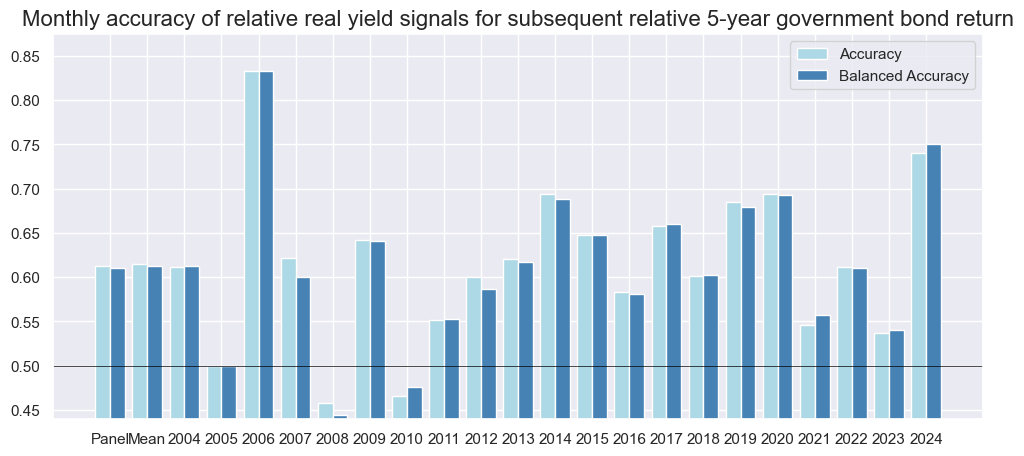

In [39]:
dix = dict_ry5br
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    size=(12, 5),
    title="Monthly accuracy of relative real yield signals for subsequent relative 5-year government bond return",
)

### Naive PnL

`NaivePnl()` class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not take into account transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

In [40]:
dix = dict_ry5br

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx, ret=targ, sigs=sigx, cids=cidx, start=start, bms=["USD_GB10YXR_NSA"]
)

dict_pnls = {
    "PZN": {"sig_add": 0, "sig_op": "zn_score_pan"},
    "BIN": {"sig_add": 0, "sig_op": "binary"},
}

for k, v in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=False,
            sig_add=v["sig_add"],
            sig_op=v["sig_op"],
            thresh=2,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + "_" + k,
        )

dix["pnls"] = naive_pnl

USD_GB10YXR_NSA has no observations in the DataFrame.


The `plot_pnls()` method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL. 

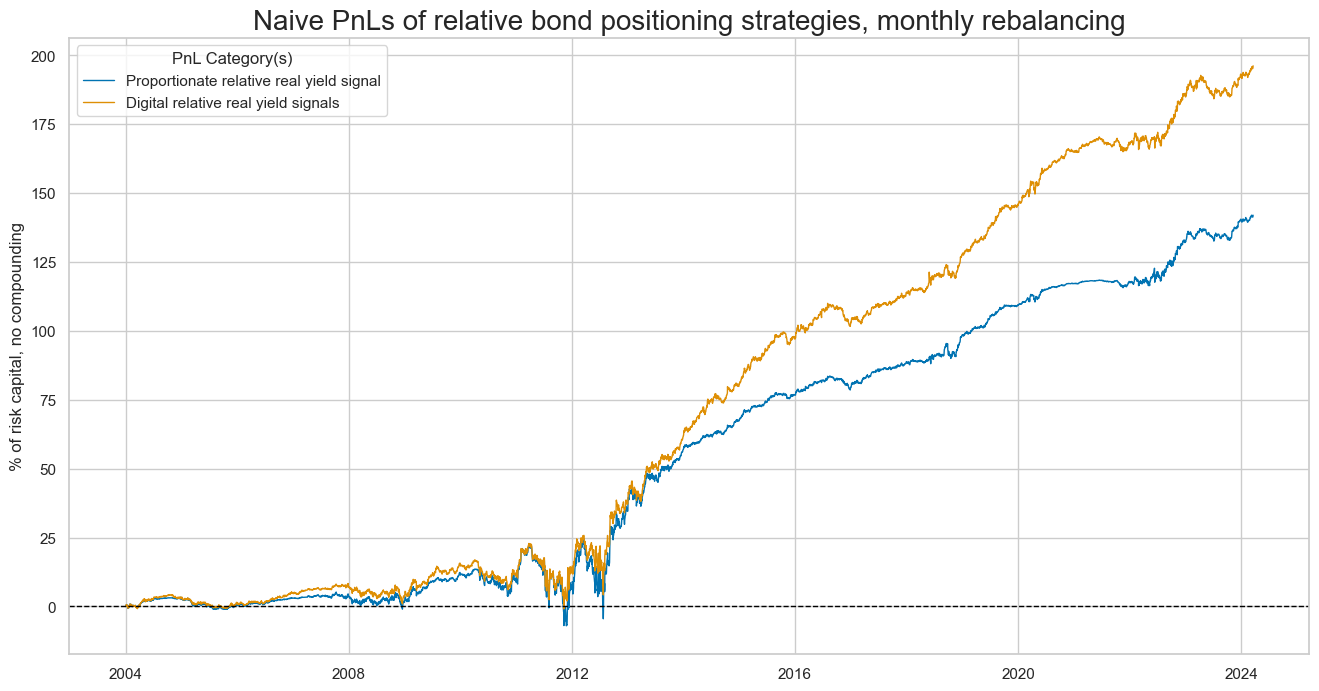

In [45]:
dix = dict_ry5br

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]]

naive_pnl = dix["pnls"]
pnls = [sig + pos for sig in sigx for pos in ["_PZN", "_BIN"]]
dict_labels={"GB05YRYLD_NSAvBM_PZN": "Proportionate relative real yield signal", "GB05YRYLD_NSAvBM_BIN": "Digital relative real yield signals"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive PnLs of relative bond positioning strategies, monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [42]:
dix = dict_ry5br

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
posx = ["_PZN", "_BIN"]

pnls = [sig + pos for sig in sigx for pos in posx]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)

In [43]:
display(df_eval.transpose())

,Return (pct ar),St. Dev. (pct ar),Sharpe Ratio,Sortino Ratio,Max 21-day draw,Max 6-month draw,Traded Months
xcat,,,,,,,
GB05YRYLD_CDAvBM_BIN,6.930918,10.0,0.693092,1.100946,-12.775247,-15.66945,244
GB05YRYLD_CDAvBM_PZN,8.423874,10.0,0.842387,1.380888,-16.498006,-22.272977,244
GB05YRYLD_NSAvBM_BIN,9.707066,10.0,0.970707,1.497091,-14.607743,-18.867274,244
GB05YRYLD_NSAvBM_PZN,7.024386,10.0,0.702439,1.071871,-18.235297,-24.024978,244


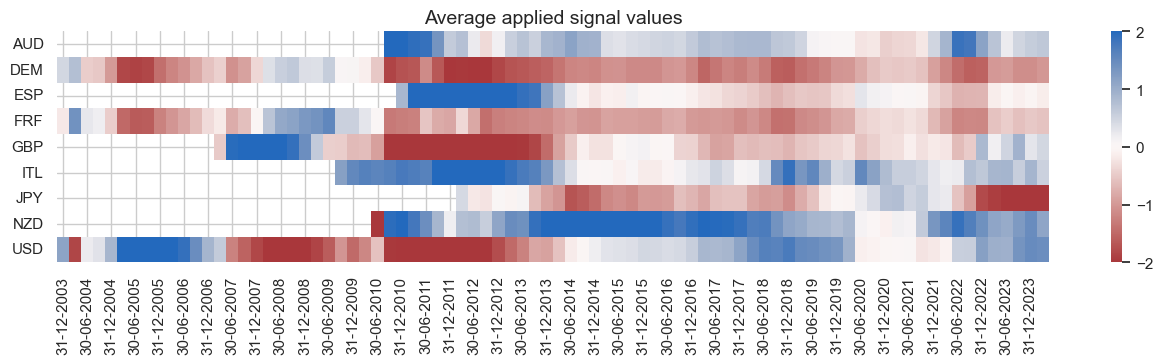

In [44]:
dix = dict_ry5br

start = dix["start"]
sig = dix["sig"]
naive_pnl = dix["pnls"]

naive_pnl.signal_heatmap(pnl_name=sig + "_PZN", freq="q", start=start, figsize=(16, 3))